<a href="https://colab.research.google.com/github/dimzog/Machine-Learning/blob/andreas/Draft_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import the Libraries

In [17]:
import warnings
warnings.filterwarnings('ignore')

!pip install unidecode
import unidecode

import seaborn as sns
sns.set(style="darkgrid")

import numpy as np
import pandas as pd
from time import time

import re
from tqdm import tqdm
from collections import defaultdict

import time
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
plt.style.use('ggplot')

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

import random
from sklearn import metrics
from sklearn.svm import SVC
from sklearn import preprocessing
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 1. Preprocessing

## Read the files

In [0]:
# You only need "train.json" in the same file with the notebook

train_df = pd.read_json('train.json')

## Drop recipes with 1 ingredient

In [0]:
train_df['num_ingredients'] = train_df['ingredients'].apply(len)
train_df = train_df[train_df['num_ingredients'] > 1]

## Preprocess

* Convert all Capitals to Lowers

* Remove (-)

* Remove numbers with percentages (for example 1%)

* Remove words with less than 2 characters

* Lemmatize

In [0]:
lemmatizer = WordNetLemmatizer()
def preprocess(ingredients):
    ingredients_text = ','.join(ingredients)
    ingredients_text = ingredients_text.lower()
    ingredients_text = ingredients_text.replace('-', ' ')
    words = []
    for word in ingredients_text.split():
        if re.findall('[0-9]', word): continue
        if len(word) <= 2: continue
        if '’' in word: continue
        word = lemmatizer.lemmatize(word)
        if len(word) > 0: words.append(word)
    return ' '.join(words)

for ingredient, expected in [
    ('Eggs', 'egg'),
    ('all-purpose flour', 'all purpose flour'),
    ('purée', 'purée'),
    ('1% low-fat milk', 'low fat milk'),
    ('half & half', 'half half'),
    ('safetida (powder)', 'safetida (powder)')
]:
    actual = preprocess([ingredient])
    assert actual == expected, f'"{expected}" is excpected but got "{actual}"'

### Add new column "separated_ingredients" with cleaned data

In [5]:
train_df['seperated_ingredients'] = train_df['ingredients'].apply(preprocess)
train_df.head()

,id,cuisine,ingredients,num_ingredients,seperated_ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",9,"romaine lettuce,black olives,grape tomatoes,ga..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",11,"plain flour,ground pepper,salt,tomatoes,ground..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12,"eggs,pepper,salt,mayonaise,cooking oil,green c..."
3,22213,indian,"[water, vegetable oil, wheat, salt]",4,"water,vegetable oil,wheat,salt"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",20,"black pepper,shallots,cornflour,cayenne pepper..."


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39752 entries, 0 to 39773
Data columns (total 5 columns):
id                       39752 non-null int64
cuisine                  39752 non-null object
ingredients              39752 non-null object
num_ingredients          39752 non-null int64
seperated_ingredients    39752 non-null object
dtypes: int64(2), object(3)
memory usage: 1.8+ MB


In [7]:
train_df.cuisine.unique()

array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

## Examining Missing Values

In [8]:
total = train_df.isnull().sum().sort_values(ascending = False)
percent = (train_df.isnull().sum()/train_df.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total missing', 'Percent missing'])
missing_train_data.head(20)

,Total missing,Percent missing
seperated_ingredients,0,0.0
num_ingredients,0,0.0
ingredients,0,0.0
cuisine,0,0.0
id,0,0.0


## Create Train and Test Data (Sparse Matrices)

* Vectorize train_df.separated_ingredients --> create X_train_vectorized

* Encode train_df.cuisine with values --> y_transformed = labels (0,..,19)

* Train & Test split (from X_train_vectorized and y_transformed) --> 80%, 20%

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

vect = TfidfVectorizer(binary=True).fit(train_df['seperated_ingredients'].values)
X_train_vectorized = vect.transform(train_df['seperated_ingredients'].values)
X_train_vectorized = X_train_vectorized.astype('float')

encoder = LabelEncoder()
y_transformed = encoder.fit_transform(train_df.cuisine)


X_train, X_test, y_train, y_test = train_test_split(X_train_vectorized, y_transformed , train_size=0.80, random_state = 0)

## Dictionary for y_train labels

In [10]:
dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

{'brazilian': 0,
 'british': 1,
 'cajun_creole': 2,
 'chinese': 3,
 'filipino': 4,
 'french': 5,
 'greek': 6,
 'indian': 7,
 'irish': 8,
 'italian': 9,
 'jamaican': 10,
 'japanese': 11,
 'korean': 12,
 'mexican': 13,
 'moroccan': 14,
 'russian': 15,
 'southern_us': 16,
 'spanish': 17,
 'thai': 18,
 'vietnamese': 19}

# 2. Knowledge Representation

## Most Frequent Cuisines

### Create Colors

In [0]:
def random_colours(number_of_colors):
    '''
    Simple function for random colours generation.
    Input:
        number_of_colors - integer value indicating the number of colours which are going to be generated.
    Output:
        Color in the following format: ['#E86DA4'] .
    '''
    colors = []
    for i in range(number_of_colors):
        colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors

### 1ος Τρόπος

In [19]:
# color_theme = dict(color = ['rgba(221,160,221,1)','rgba(169,169,169,1)','rgba(255,160,122,1)','rgba(176,224,230,1)','rgba(169,169,169,1)','rgba(255,160,122,1)',
#                             'rgba(176,224,230,1)','rgba(188,143,143,1)','rgba(221,160,221,1)','rgba(169,169,169,1)','rgba(255,160,122,1)','rgba(176,224,230,1)',
#                             'rgba(189,183,107,1)','rgba(188,143,143,1)','rgba(221,160,221,1)','rgba(169,169,169,1)','rgba(255,160,122,1)','rgba(176,224,230,1)',
#                             'rgba(169,169,169,1)','rgba(255,160,122,1)'])

temp = train_df['cuisine'].value_counts()
trace = go.Bar(y=temp.index[::-1],x=(temp / temp.sum() * 100)[::-1],orientation = 'h', marker=dict(color=random_colours(20))) # ,marker=color_theme
layout = go.Layout(title = "Top cuisine with recipe count (%)",xaxis=dict(title='Recipe count',tickfont=dict(size=14,)),
                   yaxis=dict(title='Cuisine',titlefont=dict(size=16),tickfont=dict(size=14)),margin=dict(l=200,), plot_bgcolor='rgb(255,255,255)')
data = [trace]
fig = go.Figure(data=data, layout=layout)
iplot(fig,filename='basic-bar')
temp = pd.DataFrame(temp)
temp.head()

,cuisine
italian,7837
mexican,6436
southern_us,4319
indian,2997
chinese,2673


### 2ος Τρόπος

In [20]:
labels = temp.index.tolist()
values = (temp["cuisine"]/temp["cuisine"].sum())*100

trace = go.Pie(labels=labels, values=values,hole = 0.4)

iplot([trace], filename='basic_pie_chart')

## Recipe Length Distribution by Cuisine

In [21]:
boxplotcolors = random_colours(20)
labels = [i for i in train_df.cuisine.value_counts().index][::-1]
data = []
for i in range(20):
    trace = go.Box(
    y=train_df[train_df['cuisine'] == labels[i]]['ingredients'].str.len(), name = labels[i],
    marker =  dict(color = boxplotcolors[i]))
    data.append(trace)

layout = go.Layout(title = "Recipe Length Distribution by cuisine", plot_bgcolor='rgb(255,255,255)')

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "Box Plot Styling Outliers")

## Most Frequent Ingredients in the Whole Dataset

[('salt', 18049), ('onions', 7972), ('olive oil', 7972), ('water', 7456), ('garlic', 7380), ('sugar', 6434), ('garlic cloves', 6237), ('butter', 4846), ('ground black pepper', 4785), ('all-purpose flour', 4632), ('pepper', 4438), ('vegetable oil', 4384), ('eggs', 3388), ('soy sauce', 3296), ('kosher salt', 3113), ('green onions', 3078), ('tomatoes', 3058), ('large eggs', 2948), ('carrots', 2814), ('unsalted butter', 2779)]


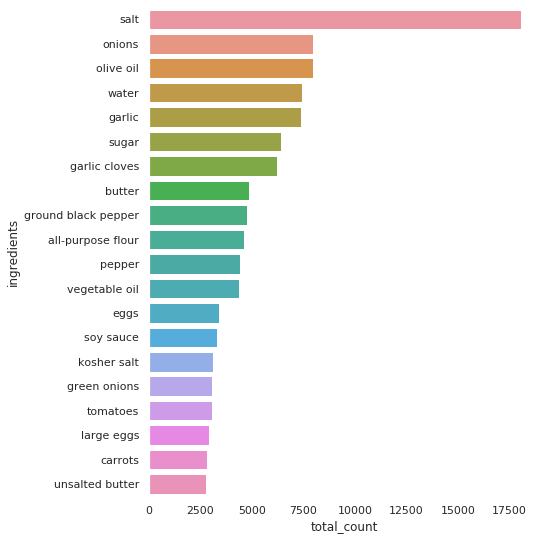

In [22]:
top = Counter([item for sublist in train_df['ingredients'] for item in sublist])
print(top.most_common(20))

temp = pd.DataFrame(top.most_common(20))
temp.columns = ['ingredients','total_count']
plt.figure(figsize=(7,9))
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.barplot(x='total_count',y='ingredients',data=temp)

## Examining Each Cuisine Seperately


In [0]:
def cuisine_dish(train, cuisine):
    temp1 = train[train['cuisine'] == cuisine]
    n=6714 # total ingredients in train data
    top = Counter([item for sublist in temp1.ingredients for item in sublist]).most_common(n)
    temp= pd.DataFrame(top)
    temp.columns = ['ingredient','total_count']
    temp = temp.head(20)
    trace0 = go.Pie(labels=temp.ingredient[::-1], values=temp.total_count[::-1],hole = 0.4)
    data = [trace0]
    fig = go.Figure(data = data, layout= dict(title = "Famous Cuisine of '"+cuisine+"'"))
    iplot(fig,filename='basic_pie_chart')

a. Greek

In [24]:
cuisine_dish(train_df,"greek")

b. Indian

In [25]:
cuisine_dish(train_df,"indian")

## Most frequent biagrams 

In [0]:
train_df['for ngrams']=train_df['seperated_ingredients'].str.replace(',',' ')
def ingre_cusine(cuisine):
    frame=train_df[train_df['cuisine']==cuisine]
    common=list(nltk.bigrams(nltk.word_tokenize(" ".join(frame['for ngrams']))))
    return pd.DataFrame(Counter(common),index=['count']).T.sort_values('count',ascending=False)[:15]

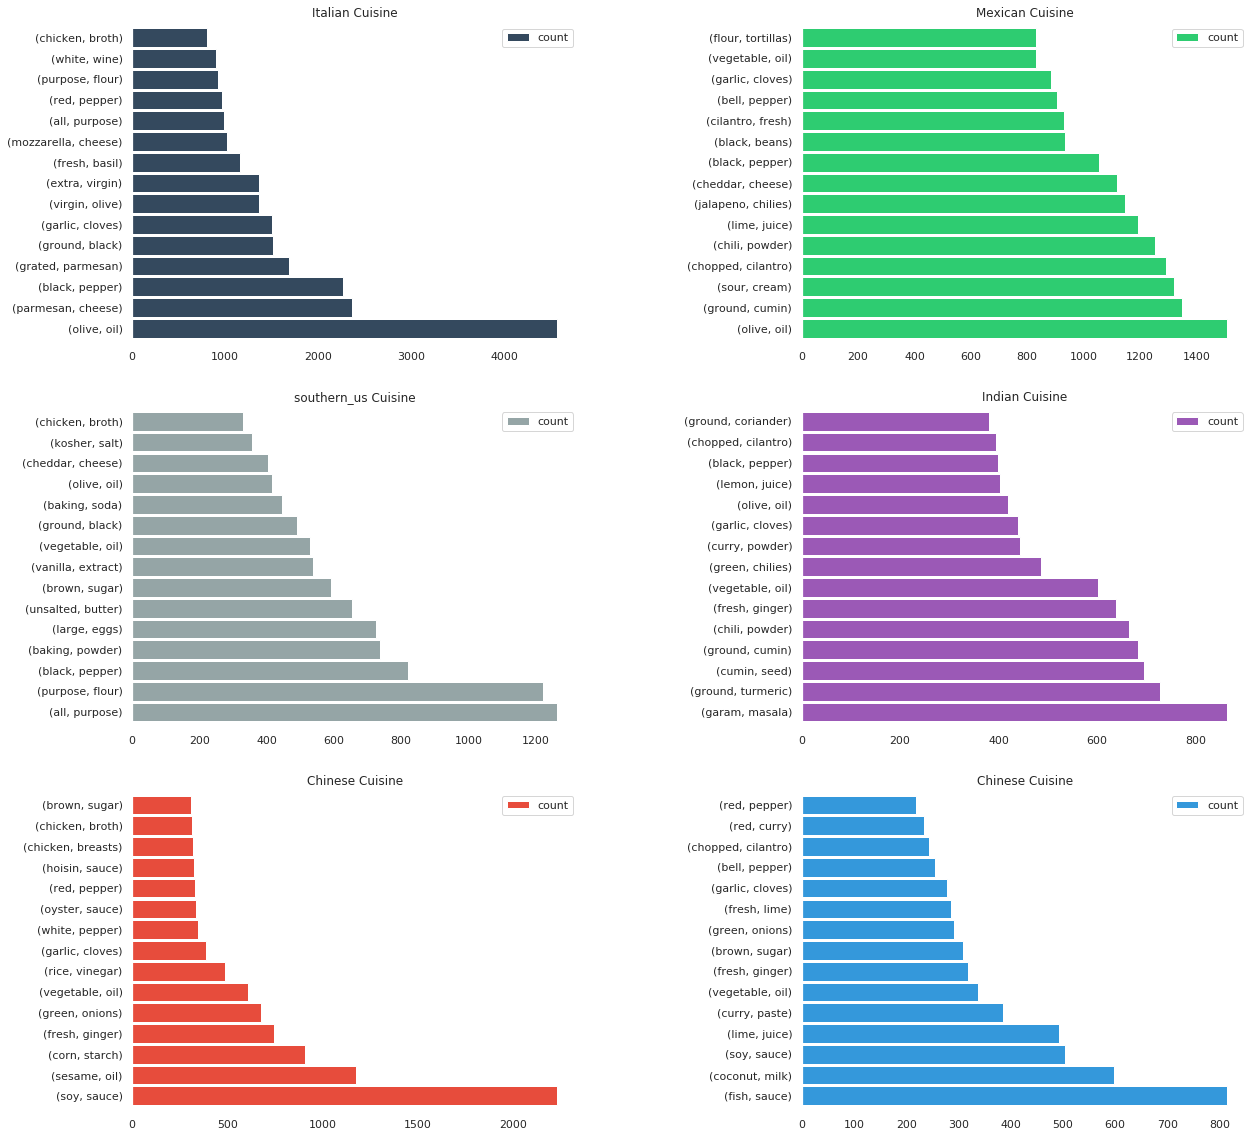

In [27]:
flatui = [ "#34495e", "#2ecc71", "#95a5a6","#9b59b6", "#e74c3c", "#3498db"]

f,ax=plt.subplots(3,2,figsize=(20,20))
ingre_cusine('italian').plot.barh(ax=ax[0,0],width=0.9,color= flatui[0])
ax[0,0].set_title('Italian Cuisine')
ingre_cusine('mexican').plot.barh(ax=ax[0,1],width=0.9,color = flatui[1] )
ax[0,1].set_title('Mexican Cuisine')
ingre_cusine('southern_us').plot.barh(ax=ax[1,0],width=0.9,color=flatui[2])
ax[1,0].set_title('southern_us Cuisine')
ingre_cusine('indian').plot.barh(ax=ax[1,1],width=0.9,color=flatui[3])
ax[1,1].set_title('Indian Cuisine')
ingre_cusine('chinese').plot.barh(ax=ax[2,0],width=0.9,color=flatui[4])
ax[2,0].set_title('Chinese Cuisine')
ingre_cusine('thai').plot.barh(ax=ax[2,1],width=0.9,color=flatui[5])
ax[2,1].set_title('Chinese Cuisine')
plt.subplots_adjust(wspace=0.5)

## Create Biagrams

In [0]:
import networkx as nx
def generate_ngrams(text, n):
    words = text.split(' ')
    iterations = len(words) - n + 1
    for i in range(iterations):
        yield words[i:i + n]


def net_diagram(*cuisines):
    ngrams = {}
    for title in train_df[train_df.cuisine==cuisines[0]]['for ngrams']:
            for ngram in generate_ngrams(title, 2):
                ngram = ','.join(ngram)
                if ngram in ngrams:
                    ngrams[ngram] += 1
                else:
                    ngrams[ngram] = 1

    ngrams_mws_df = pd.DataFrame.from_dict(ngrams, orient='index')
    ngrams_mws_df.columns = ['count']
    ngrams_mws_df['cusine'] = cuisines[0]
    ngrams_mws_df.reset_index(level=0, inplace=True)

    ngrams = {}
    for title in train_df[train_df.cuisine==cuisines[1]]['for ngrams']:
            for ngram in generate_ngrams(title, 2):
                ngram = ','.join(ngram)
                if ngram in ngrams:
                    ngrams[ngram] += 1
                else:
                    ngrams[ngram] = 1

    ngrams_mws_df1 = pd.DataFrame.from_dict(ngrams, orient='index')
    ngrams_mws_df1.columns = ['count']
    ngrams_mws_df1['cusine'] = cuisines[1]
    ngrams_mws_df1.reset_index(level=0, inplace=True)
    cuisine1=ngrams_mws_df.sort_values('count',ascending=False)[:25]
    cuisine2=ngrams_mws_df1.sort_values('count',ascending=False)[:25]
    df_final=pd.concat([cuisine1,cuisine2])
    g = nx.from_pandas_edgelist(df_final,source='cusine',target='index')
    cmap = plt.cm.RdYlGn
    colors = [n for n in range(len(g.nodes()))]
    k = 0.35
    pos=nx.spring_layout(g, k=k)
    nx.draw_networkx(g,pos, node_size=df_final['count'].values*8, cmap = cmap, node_color=colors, edge_color='grey', font_size=20, width=3)
    plt.title("Top 25 Bigrams for %s and %s" %(cuisines[0],cuisines[1]), fontsize=20)
    plt.gcf().set_size_inches(30,30)
    plt.show()
    plt.savefig('network.png')

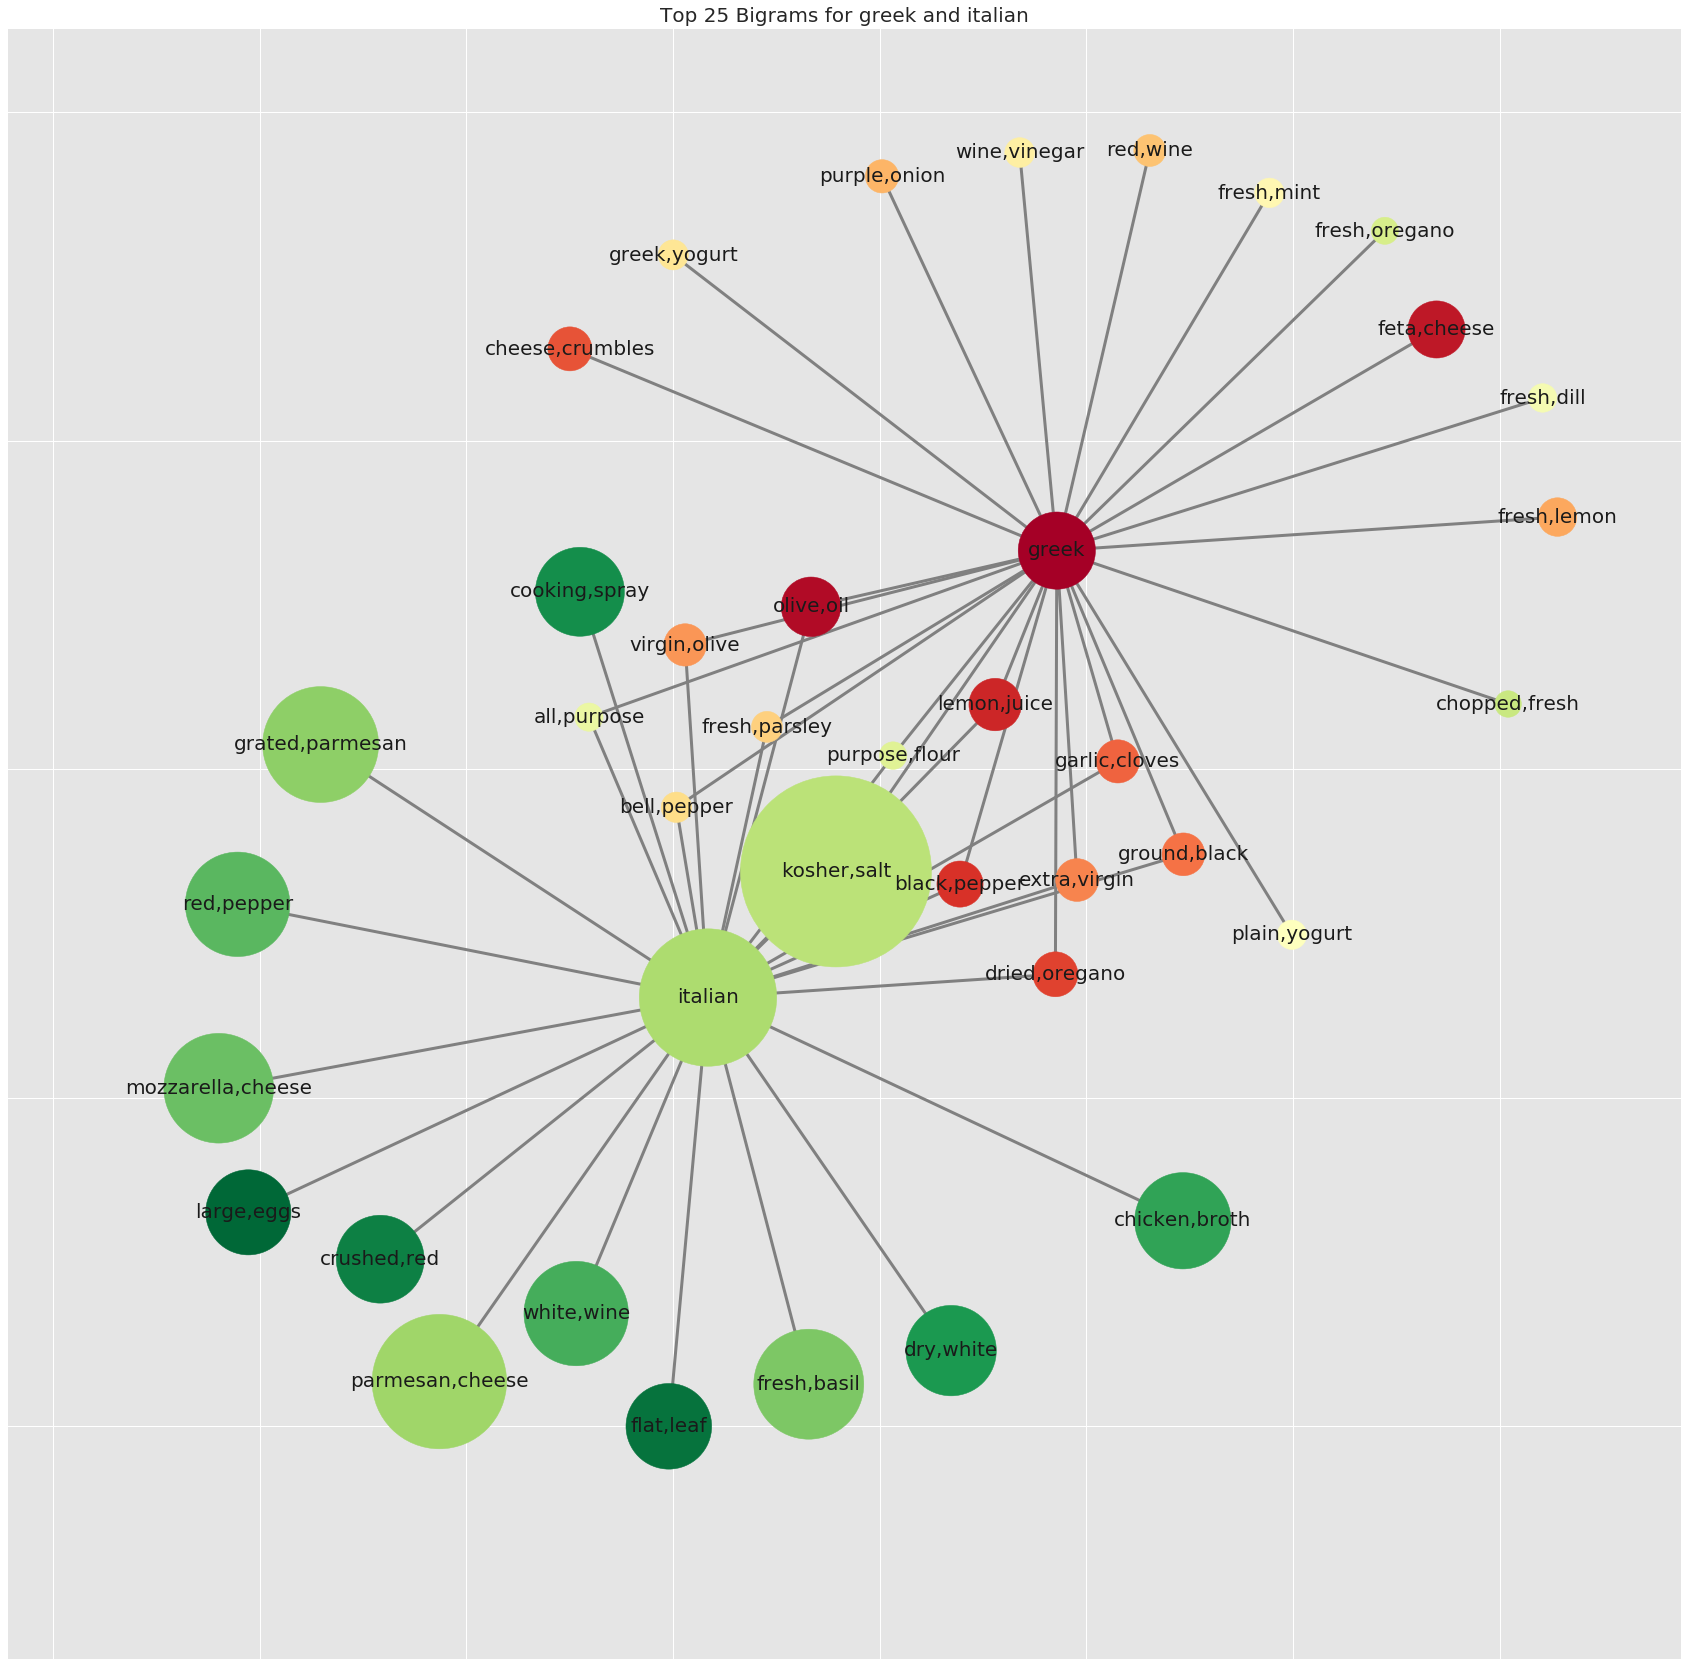

<Figure size 432x288 with 0 Axes>

In [20]:
net_diagram('greek','italian')

# Machine Learning with Sparse Data

## Logistic Regression

In [29]:
t = time.time()

# -------------------------- Logistic Regression Classifier -----------------------------------------

clf_logreg = LogisticRegression()
clf_logreg.fit(X_train, y_train)
y_pred_lr = clf_logreg.predict(X_test)

print('Logistic Regression Accuracy  (in %) : {0:0.2f}'. format(accuracy_score(y_test, y_pred_lr)*100))

elapsed = time.time() - t
print()
print("Χρόνος Εκτέλεσης Προγράμματος: {} min".format(round(elapsed/60,1)))

Logistic Regression Accuracy  (in %) : 78.34

Χρόνος Εκτέλεσης Προγράμματος: 0.2 min


## Decision Tree

In [31]:
t = time.time()

# ----------------------------- Decision Tree Classifier --------------------------------------------

clf_tree = DecisionTreeClassifier()
clf_tree.fit(X_train, y_train)                       
y_pred_dt = clf_tree.predict(X_test)                   


sum1=0
for i in range(len(y_pred_dt)):
    if y_pred_dt[i] == y_test[i]:
        sum1+=1
        
print("Decision Tree Accuracy (in %) : {0:0.2f}" .format(np.round(100*sum1/len(y_test),2)))

elapsed = time.time() - t
print()
print("Χρόνος Εκτέλεσης Προγράμματος: {} min".format(round(elapsed/60,1)))

Decision Tree Accuracy (in %) : 60.89

Χρόνος Εκτέλεσης Προγράμματος: 0.2 min


## K-Nearest Neighboor

KNN Accuracy (in %) : 74.51 

Χρόνος Εκτέλεσης Προγράμματος: 1.2 min


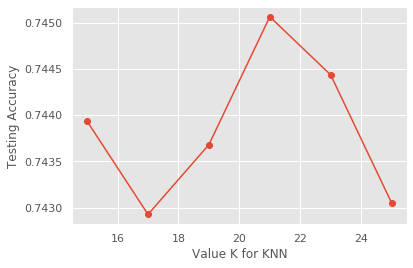

In [24]:
t = time.time()

# --------------------------- K-Nearest Neighboor Classifier -------------------


k_range=range(15,27,2)
scores={}
scores_list=[]

for k in k_range:
    clf_knn=KNeighborsClassifier(n_neighbors=k)
    clf_knn.fit(X_train,y_train)
    y_pred_knn=clf_knn.predict(X_test)
    scores_list.append(metrics.accuracy_score(y_test,y_pred_knn))
    
plt.plot(k_range,scores_list,  marker="o")
plt.xlabel("Value K for KNN")
plt.ylabel("Testing Accuracy")

print("KNN Accuracy (in %) : {0:0.2f} " .format(round(max(scores_list)*100,2)))


elapsed = time.time() - t
print()
print("Χρόνος Εκτέλεσης Προγράμματος: {} min".format(round(elapsed/60,1)))

### Save the best performance of KNN

In [32]:
t = time.time()

# --------------------------- K-Nearest Neighboor Classifier -------------------

clf_knn=KNeighborsClassifier(n_neighbors=21)
clf_knn.fit(X_train,y_train)
y_pred_knn=clf_knn.predict(X_test)

acc_knn=accuracy_score(y_test, y_pred_knn)

print("K-Nearest Neighbor Accuracy (in %) : {0:0.2f}" .format(100*acc_knn))

elapsed = time.time() - t
print()
print("Χρόνος Εκτέλεσης Προγράμματος: {} min".format(round(elapsed/60,1)))

K-Nearest Neighbor Accuracy (in %) : 74.51

Χρόνος Εκτέλεσης Προγράμματος: 0.2 min


## Random Forest

In [33]:
t = time.time()

#  --------------------- Random Forest Classifier -------------------------------

rlf = RandomForestClassifier(n_estimators=100, max_features="auto",random_state=0)
rlf.fit(X_train, y_train)
y_pred_rlf = rlf.predict(X_test)
accRF=accuracy_score(y_test, y_pred_rlf)

print("Random Forest Accuracy (in %) : {0:0.2f}" .format(100*accRF))

elapsed = time.time() - t
print()
print("Χρόνος Εκτέλεσης Προγράμματος: {} min".format(round(elapsed/60,1)))

Random Forest Accuracy (in %) : 74.20

Χρόνος Εκτέλεσης Προγράμματος: 1.0 min


## Multinomial Naive Bayes


In [34]:
t = time.time()

#  ------------------- Multinomial Naive Bayes Classifier ----------------------

from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train,y_train)
y_pred_mnb = mnb.predict(X_test)

print('Multinomial Naive Bayes Accuracy  (in %) : {0:0.2f}'. format(accuracy_score(y_test,y_pred_mnb )*100))

elapsed = time.time() - t
print()
print("Χρόνος Εκτέλεσης Προγράμματος: {} min".format(round(elapsed/60,1)))

Multinomial Naive Bayes Accuracy  (in %) : 66.95

Χρόνος Εκτέλεσης Προγράμματος: 0.0 min


## Kernel SVM (RBF)

In [35]:
t = time.time()

#  ------------------- Kernel SVM (RBF) Classifier -----------------

svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train, y_train)
y_pred_svm = svclassifier.predict(X_test)

print(classification_report(y_test,y_pred_svm))

elapsed = time.time() - t
print()
print("Χρόνος Εκτέλεσης Προγράμματος: {} min".format(round(elapsed/60,1)))

              precision    recall  f1-score   support

           0       0.92      0.50      0.65        88
           1       0.57      0.39      0.46       167
           2       0.85      0.75      0.80       335
           3       0.77      0.89      0.82       544
           4       0.86      0.63      0.73       150
           5       0.61      0.69      0.65       533
           6       0.85      0.73      0.79       252
           7       0.84      0.92      0.88       595
           8       0.76      0.53      0.62       134
           9       0.79      0.91      0.85      1514
          10       0.93      0.68      0.79       110
          11       0.86      0.70      0.77       296
          12       0.92      0.73      0.81       182
          13       0.90      0.92      0.91      1272
          14       0.91      0.71      0.79       178
          15       0.84      0.37      0.51       101
          16       0.70      0.82      0.76       821
          17       0.81    

## Precision, Recall and F1 score 

In [36]:
print("Logistic Regression metrics:", precision_recall_fscore_support(y_test,y_pred_lr, average="macro")[0:3])
print("\nDecision Tree metrics:",precision_recall_fscore_support(y_test,y_pred_dt, average="macro")[0:3])
print("\nK-Nearest Neighbor metrics:",precision_recall_fscore_support(y_test,y_pred_knn, average="macro")[0:3])
print("\nRandom Forest metrics:",precision_recall_fscore_support(y_test,y_pred_rlf, average="macro")[0:3])
print("\nKernel SVM metrics:",precision_recall_fscore_support(y_test,y_pred_svm, average="macro")[0:3])

Logistic Regression metrics: (0.7708964872082932, 0.6612140499236151, 0.7014321613818757)

Decision Tree metrics: (0.5117269463700984, 0.49254469498323783, 0.5006431682350952)

K-Nearest Neighbor metrics: (0.7445182670055203, 0.6118374601008424, 0.6560341403192868)

Random Forest metrics: (0.7906208702415825, 0.5828768519427159, 0.6427443819604541)

Kernel SVM metrics: (0.8076514554376318, 0.6821377664879188, 0.7281466759416496)


In [0]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

def roc(y_test, y_pred):

  n_classes=20
  y_test = label_binarize(y_test, classes=[i for i in range(n_classes)])
  y_pred = label_binarize(y_pred, classes=[i for i in range(n_classes)])

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()

  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  return fpr["micro"], tpr["micro"], roc_auc["micro"]

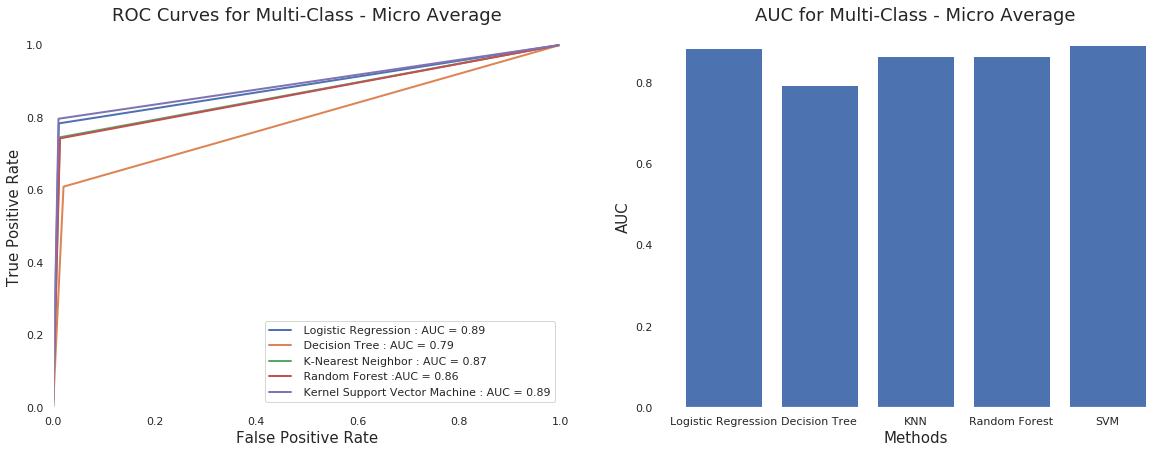

In [91]:
8, 45]
ax2sset_'
ss -set_xticklabelsr bars20)_pos = np.arange(len(bars))
ax2.set_xticks(y_pos bars)ax2.set_xlabel('FUCalse Posi
# ive Rate',  siznp.arange(len(bars)), e=15)
ax1.set_ylabel('True18ositive Rate',  size=15)
figrset_set_eate bar
s
ax1.se1bar(y_,  siz
e=15pos, hg
(bars)plt.show() 
lt.subplots_adjust(hspace = .001)
ames on th] x
-axis
plbarscks(y_pos, bars)
Aow g7aphi, f, size=20ig5ze=(20,10)cax111t_ogle.colab impo18 files
pUCl111 roc_auc_lrtx roc_auc_dtt1 roc_auc_knn ) roc_auc_rlf2_ roc_auc_svm filesubpl1,2otsload("abc.png")plt.savefig("abc.png")
